In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip '/content/drive/My Drive/Distracted driver detection dataset.zip'

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
data_dir = '/content/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}


In [8]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class_names

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

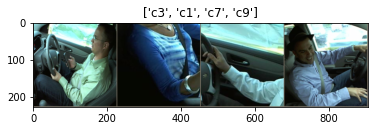

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [81]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9936 Acc: 0.6800
val Loss: 0.1492 Acc: 0.9515

Epoch 1/24
----------
train Loss: 0.6190 Acc: 0.8009
val Loss: 0.1447 Acc: 0.9576

Epoch 2/24
----------
train Loss: 0.4927 Acc: 0.8424
val Loss: 0.0765 Acc: 0.9788

Epoch 3/24
----------
train Loss: 0.4578 Acc: 0.8545
val Loss: 0.0498 Acc: 0.9848

Epoch 4/24
----------
train Loss: 0.4016 Acc: 0.8722
val Loss: 0.0589 Acc: 0.9848

Epoch 5/24
----------
train Loss: 0.3684 Acc: 0.8817
val Loss: 0.0400 Acc: 0.9939

Epoch 6/24
----------
train Loss: 0.3509 Acc: 0.8878
val Loss: 0.0183 Acc: 0.9939

Epoch 7/24
----------
train Loss: 0.2665 Acc: 0.9132
val Loss: 0.0206 Acc: 0.9970

Epoch 8/24
----------
train Loss: 0.2455 Acc: 0.9182
val Loss: 0.0198 Acc: 0.9970

Epoch 9/24
----------
train Loss: 0.2307 Acc: 0.9241
val Loss: 0.0199 Acc: 0.9970

Epoch 10/24
----------
train Loss: 0.2253 Acc: 0.9254
val Loss: 0.0166 Acc: 0.9970

Epoch 11/24
----------
train Loss: 0.2200 Acc: 0.9268
val Loss: 0.0152 Acc: 0.9970

Ep

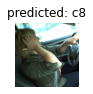

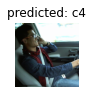

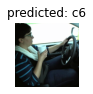

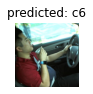

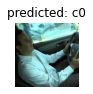

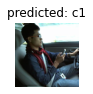

In [82]:
visualize_model(model_ft)

In [108]:
torch.save(model_ft, 'resnet1.pth')

In [112]:

import pandas as pd
df = pd.DataFrame({'images':[],'c0':[], 'c1':[],'c2':[], 'c3':[], 'c4':[],'c5':[], 'c6':[], 'c7':[], 'c8':[], 'c9':[]})

In [113]:
import os
import cv2
import glob
from PIL import Image
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
def _submission(pathPropagate_Images,df,model):
    model.eval()
    for imgs in glob.glob(os.path.join(pathPropagate_Images,'*.jpg')):
        img_cv = cv2.imread(imgs)
        image = trans(Image.fromarray(img_cv))
        image = image.view(1,3,224,224)
        
        with torch.no_grad():
          arr_predict = model(image.to(device))
       
        df = df.append(
            {
                'images':imgs.split('/')[-1],
                'c0':(arr_predict[0][0]).data.cpu().numpy(), 
                'c1':(arr_predict[0][1]).data.cpu().numpy(),
                'c2':(arr_predict[0][2]).data.cpu().numpy(),
                'c3':(arr_predict[0][3]).data.cpu().numpy(),
                'c4':(arr_predict[0][4]).data.cpu().numpy(),
                'c5':(arr_predict[0][5]).data.cpu().numpy(),
                'c6':(arr_predict[0][6]).data.cpu().numpy(),
                'c7':(arr_predict[0][7]).data.cpu().numpy(),
                'c8':(arr_predict[0][8]).data.cpu().numpy(),
                'c9':(arr_predict[0][9]).data.cpu().numpy()
            },
            ignore_index=True
        )
    return df

In [114]:
# !unzip '/content/drive/My Drive/test.zip'

In [115]:
pathPropagate_Images =  "/content/test"
df = _submission(pathPropagate_Images,df,model_ft)

In [116]:
# help(torch.round)
df.head()

,images,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_87281.jpg,2.2807338,3.3545618,-6.4952927,-5.8398256,-4.5990453,-1.4196565,3.394537,3.6530113,6.8458323,-1.2562864
1,img_4408.jpg,5.3701906,0.05766934,-0.8361366,-4.199613,-3.3644567,6.6730676,-4.1804695,-0.37870568,3.5702772,-2.8535044
2,img_23895.jpg,2.0664945,3.297095,-6.4743047,-4.522679,-3.4443445,0.9234893,-1.0288117,4.7612777,0.40351316,3.7580671
3,img_41358.jpg,2.448763,1.6318617,4.6333923,-3.2448497,0.3794908,0.58067614,-1.24957,-2.6859226,-3.010473,0.5607468
4,img_82530.jpg,4.9451313,-1.3812613,1.8307172,4.82562,-0.093773976,-1.0450082,-1.6160545,-0.8746405,-3.5316052,-3.037317


In [117]:
df.to_csv('submission_file.csv',index = False)